# Ethiopia Renewable Energy Potential Analysis - Annual Patterns

## 1. Setup and Data Preparation
### 1.1 Import Dependencies

In [1]:
# Core geospatial and data analysis libraries
import geopandas as gpd
import xarray as xr
from atlite import Cutout, ExclusionContainer
import matplotlib.pyplot as plt
import logging

# Configuration and visualization setup
plt.rc("figure", figsize=[10, 7])
logging.basicConfig(level=logging.INFO)

C:\Users\kumab\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\kumab\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### 1.2 Data Paths and Parameters

In [4]:
# Administrative boundaries
SHAPEFILE = "../shapefiles/eth_admbnda_adm0_csa_bofedb_itos_2021.shp"

# Exclusion data sources
PROTECTED_AREAS = "../shapefiles/WDPA_WDOECM_Jan2025_Public_ETH_shp-polygons.shp"
POPULATION_DENSITY = "../rasters/popoulation_500_ETH2.tif"
ELEVATION_DATA = "https://drive.google.com/file/d/1stZr0rz7AOTzjm4D4YmiMBdAtUaiygt2/view?usp=drive_link"

# Energy parameters
CAPACITY_PER_SQKM = 1.9  # MW/km² for both technologies

### 1.3 Base Dataset Preparation

In [ ]:
# Load country boundary
import atlite
from atlite import Cutout, ExclusionContainer


country = gpd.read_file(SHAPEFILE)
bounds=country.geometry.unary_union.buffer(1).bounds
Create ERA5 cutout for 2023
cutout = Cutout(
    path="../cutout/Ethiopia_Annual_2023",
    module="era5",
    bounds=bounds,
    time=slice("2023-01-01", "2023-12-31")
)
cutout.prepare(monthly_requests=True)

## 2. Wind Energy Analysis

### 2.1 Exclusion Criteria

Densely populated areas (>500 people/km²)

Protected areas

Elevation > 2000 m

In [ ]:
wind_exclusions = ExclusionContainer()
wind_exclusions.add_geometry(PROTECTED_AREAS)
wind_exclusions.add_raster(POPULATION_DENSITY)
wind_exclusions.add_raster(ELEVATION_DATA)

### 2.2 Availability Calculation

In [125]:
country_wind = country.geometry.to_crs(wind_exclusions.crs)
wind_mask,transform = wind_exclusions.compute_shape_availability(country_wind)
wind_share = wind_mask.sum() * wind_exclusions.res**2 / country_wind.area.item()
print(f"Wind eligible area: {wind_share:.2%}")

C:\Users\kumab\anaconda3\lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Wind eligible area: 0.02%


C:\Users\kumab\AppData\Local\Temp\ipykernel_13244\2364524900.py:3: RuntimeWarning: overflow encountered in scalar multiply
  wind_share = wind_mask.sum() * wind_exclusions.res**2 / country_wind.area.item()


### 2.3 Capacity and Generation

In [126]:
# Calculate capacity matrix
area =cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

wind_capacity_matrix = cutout.availabilitymatrix(country, wind_exclusions)
wind_capacity = (wind_capacity_matrix.stack(spatial=["y", "x"] )*area*CAPACITY_PER_SQKM)

# Simulate wind generation
wind_generation = cutout.wind(
    matrix=wind_capacity,
    turbine=atlite.windturbines.Enercon_E101_3000kW,
    interpolation_method="logarithmic",
    index=country.index,)

C:\Users\kumab\anaconda3\lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


## 3. Solar PV Analysis
### 3.1 Exclusion Criteria
Densely populated areas (>500 people/km²)

Protected areas

In [127]:
pv_exclusions = ExclusionContainer()
pv_exclusions.add_geometry(PROTECTED_AREAS)
pv_exclusions.add_raster(POPULATION_DENSITY)

### 3.2 Availability Calculation

In [128]:
country_pv = country.geometry.to_crs(pv_exclusions.crs)
pv_mask, _ = pv_exclusions.compute_shape_availability(country_pv)
pv_share = pv_mask.sum() * pv_exclusions.res**2 / country_pv.area.item()
print(f"PV eligible area: {pv_share:.2%}")

C:\Users\kumab\anaconda3\lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


PV eligible area: -0.06%


C:\Users\kumab\AppData\Local\Temp\ipykernel_13244\681484138.py:3: RuntimeWarning: overflow encountered in scalar multiply
  pv_share = pv_mask.sum() * pv_exclusions.res**2 / country_pv.area.item()


### 3.3 Capacity and Generation

In [129]:
# Calculate capacity matrix

pv_capacity_matrix = cutout.availabilitymatrix(country, pv_exclusions)
pv_capacity = (pv_capacity_matrix.stack(spatial=["y", "x"]) *area*CAPACITY_PER_SQKM) 
             

# Simulate PV generation
pv_generation = cutout.pv(
    matrix=pv_capacity,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=country.index)

INFO:atlite.convert:Convert and aggregate 'pv'.


## 4. Technology Overlap Analysis
### 4.1 Spatial Overlap Calculation

In [130]:
overlap_matrix = pv_capacity_matrix * wind_capacity_matrix
solar_area = pv_capacity_matrix.sum().values  # Sum of fractional values
wind_area = wind_capacity_matrix.sum().values
overlap_matrix_area=overlap_matrix.sum().values
union_area = solar_area + wind_area - overlap_matrix_area
total_overlap = overlap_matrix.sum().item()
overlap_percentage = (overlap_matrix_area / union_area) * 100
print(f"Technology overlap: {overlap_percentage:.1f}% of eligible areas")

Technology overlap: -100.0% of eligible areas


## 5. Visualization Framework
### 5.1 Common Visualization Elements


In [131]:
def create_base_map(ax, title):
    """Create standardized map elements"""
    country.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.6)
    cutout.grid.plot(ax=ax, edgecolor="grey", color="None", ls=":")
    ax.set_title(title, fontsize=14, pad=20)
    ax.axis('off')

### 5.2 Availability Plotting

In [132]:
def plot_availability(matrix, ax, tech_name, cmap):
    """Plot technology availability matrix"""
    matrix.plot(ax=ax, cmap=cmap, add_colorbar=False, alpha=0.8)
    create_base_map(ax, f"{tech_name} Site Availability")
    plt.colorbar(ax.collections[0], ax=ax).set_label('Availability Fraction')

### 5.3 Generation Profile Plotting

In [133]:
def plot_generation_profile(series, ax, tech_name):
    """Plot normalized generation profile"""
    (series / series.max()).plot(ax=ax, ls="--")
    ax.set_ylabel("Normalized Output")
    ax.set_title(f"{tech_name} Generation Profile")


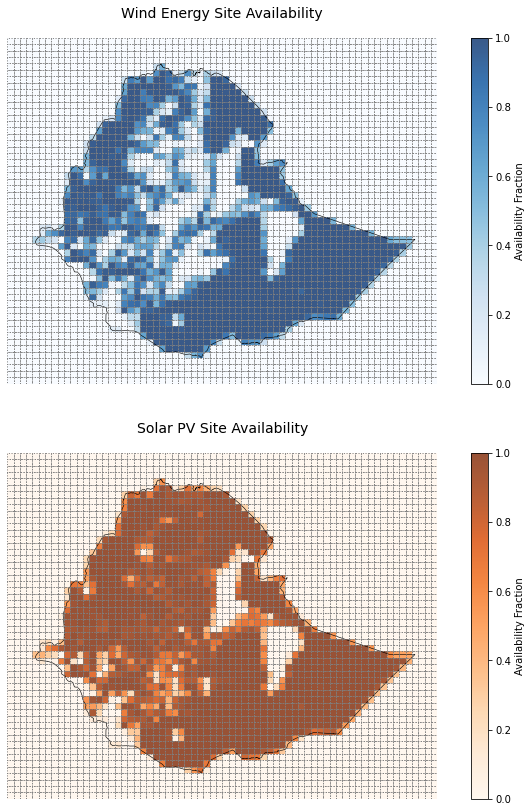

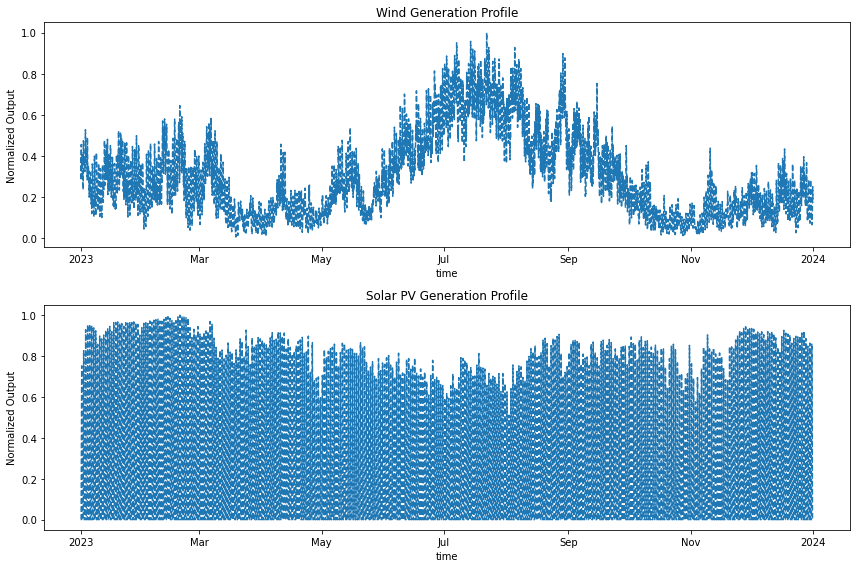

In [134]:
# 1. First create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 14))

# 2. Call availability plotting functions
plot_availability(
    matrix=wind_capacity_matrix,  # Your precomputed wind availability matrix
    ax=ax1,
    tech_name="Wind Energy",
    cmap="Blues"
)

plot_availability(
    matrix=pv_capacity_matrix,  # Your precomputed PV availability matrix
    ax=ax2,
    tech_name="Solar PV",
    cmap="Oranges"
)

# 3. Create separate figure for generation profiles
fig2, (ax3, ax4) = plt.subplots(nrows=2, figsize=(12, 8))

# 4. Call generation profile functions
plot_generation_profile(
    series=wind_generation,  # Your precomputed wind generation DataArray
    ax=ax3,
    tech_name="Wind"
)

plot_generation_profile(
    series=pv_generation,  # Your precomputed PV generation DataArray
    ax=ax4,
    tech_name="Solar PV"
)

# 5. Adjust layout and display
plt.tight_layout()
plt.show()